<a href="https://colab.research.google.com/github/NavajasThomaz/TumorVision/blob/main/Tumor_Vision_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [ ]:
!pip install vtk
!pip install PyQt5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 12.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import sys
import vtk
import time
import random
import pickle
import itertools
import tensorflow as tf
from PyQt5 import QtCore, QtWidgets
from vtk.qt.QVTKRenderWindowInteractor import QVTKRenderWindowInteractor
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

# Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Diretórios

In [ ]:
DATADIR = "/content/drive/MyDrive/TumorVision/Datasets"
MODE = ["Testing", "Training"]
CATEGORIES = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
SUBCATEGORIE = ["Superior", "Frontal", "Lateral"]

# Treinamento

# Criando data do treino/teste

In [ ]:
training_data = []
cropped_data = []
testing_data = []

In [ ]:
IMG_SIZE = 230 #@param {type:"slider", min:10, max:500, step:1}

In [ ]:
combinacoes = list(itertools.product(range(len(CATEGORIES)), range(len(SUBCATEGORIE))))

# Resultado
print(combinacoes)

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]


In [ ]:
def crop_brain_image(img):

    # Aplicação do filtro de desfoque gaussiano
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # Limiarização adaptativa
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Operações de erosão e dilatação para remover ruído
    kernel = np.ones((5, 5), np.uint8)
    eroded = cv2.erode(thresh, kernel, iterations=1)
    dilated = cv2.dilate(eroded, kernel, iterations=1)

    # Encontrar contornos
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Encontrar o maior contorno (presumindo que seja o contorno do cérebro)
        max_contour = max(contours, key=cv2.contourArea)

        # Desenhar o contorno azul claro na imagem original
        contour_img = img.copy()
        cv2.drawContours(contour_img, [max_contour], 0, (0, 0, 255), 2)  # Vermelho

        # Obter o retângulo delimitador para recortar a região do cérebro
        x, y, w, h = cv2.boundingRect(max_contour)

        # Recortar a região do cérebro
        cropped_img = img[y:y+h, x:x+w]  # Imagem recortada

        return cropped_img, contour_img
    else:
        return None, None  # Não foi possível encontrar contornos válidos

In [ ]:
def augment_data(training_data):
    augmented_data = []

    for features, label in training_data:
        # Adiciona o item original à lista
        augmented_data.append([features, label])

        # Aplica redimensionamento
        #resized_features = cv2.resize(features, (features.shape[0]+random.randint(-10,10), features.shape[1]+random.randint(-10,10)))
        #augmented_data.append([resized_features, label])

        # Aplica espelhamento horizontal
        flipped_features = cv2.flip(features, 1)
        augmented_data.append([flipped_features, label])

        # Aplica adição de ruído
        noised_features = add_noise(features)
        augmented_data.append([noised_features, label])

        # Outras manipulações podem ser adicionadas aqui

    return augmented_data

In [ ]:
def add_noise(image):
    # Gera ruído gaussiano com média zero e desvio padrão de 25
    mean = 0
    std_dev = 25
    noise = np.random.normal(mean, std_dev, image.shape).astype(np.uint8)

    # Adiciona o ruído à imagem
    noisy_image = cv2.add(image, noise)
    return noisy_image

In [ ]:
def create_training_data():
  for mode in MODE:

    class_num = 0

    # Cada classificação de tumor
    for category in CATEGORIES:

    # Cada perspectiva
      for subcategory in SUBCATEGORIE:
        path = os.path.join(DATADIR, mode, category, subcategory)
        #print(class_num)

        # Cada imagem na pasta
        for img in os.listdir(path):
          try:
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)

            newimg_array, contour_img = crop_brain_image(img_array)
            if img_array is not None:
              new_array = cv2.resize(newimg_array, (IMG_SIZE, IMG_SIZE))
              #print(new_array.shape)
              if mode == "Training":
                training_data.append([new_array, class_num])
                cropped_data.append([contour_img, class_num])
              else:
                testing_data.append([new_array, class_num])
          except Exception as e:
            print(e)
        class_num += 1


In [ ]:
create_training_data()

In [ ]:
backup = training_data

In [ ]:
print(len(training_data))

2870


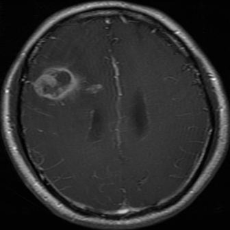

In [ ]:
cv2_imshow(training_data[4][0])

In [ ]:
print(len(training_data))

2870


In [ ]:
#Imagens
X = []
Xt = []

#Labels
y = []
yt = []

In [ ]:
training_data = backup

In [ ]:
training_data = augment_data(training_data)

In [ ]:
random.shuffle(training_data)

In [ ]:
for features, label in training_data:
    X.append(features)
    y.append(label)

for features, label in testing_data:
    Xt.append(features)
    yt.append(label)

In [ ]:
print(len(X))
print(len(y))
print(len(Xt))
print(len(yt))

8610
8610
394
394


In [ ]:
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X = X/255.0
y = np.array(y)

Xt = np.array(Xt).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
yt = np.array(yt)

In [ ]:
pickle_out = open("/content/drive/MyDrive/TumorVision/Datasets/Training/pickle/X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/TumorVision/Datasets/Training/pickle/y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/TumorVision/Datasets/Testing/pickle/Xt.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/TumorVision/Datasets/Testing/pickle/yt.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

# Modelo

##Antigo

In [ ]:
model = Sequential()

model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))

model.add(Flatten())

#dropOut

model.add(Dense(64))
model.add(Activation("relu"))

model.add(Dense(7))
#model.add(Activation('relu'))
model.add(Activation('softmax'))

## Novo

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=X.shape[1:]))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [ ]:
model.fit(X, y, batch_size=1, epochs=10, validation_split=0.3)

Epoch 1/10
6027/6027 [==============================] - 3743s 620ms/step - loss: 1.6554 - accuracy: 0.4352 - val_loss: 0.8988 - val_accuracy: 0.6686
Epoch 2/10
6027/6027 [==============================] - 3503s 581ms/step - loss: 0.8775 - accuracy: 0.6871 - val_loss: 0.6181 - val_accuracy: 0.7832
Epoch 3/10
6027/6027 [==============================] - 3410s 566ms/step - loss: 0.5810 - accuracy: 0.8011 - val_loss: 0.6963 - val_accuracy: 0.7530
Epoch 4/10
6027/6027 [==============================] - 3466s 575ms/step - loss: 0.4157 - accuracy: 0.8644 - val_loss: 0.6322 - val_accuracy: 0.8076
Epoch 5/10
6027/6027 [==============================] - 3393s 563ms/step - loss: 0.3395 - accuracy: 0.8883 - val_loss: 0.6166 - val_accuracy: 0.8463
Epoch 6/10
6027/6027 [==============================] - 3430s 569ms/step - loss: 0.2815 - accuracy: 0.9069 - val_loss: 0.4787 - val_accuracy: 0.8765
Epoch 7/10
6027/6027 [==============================] - 3422s 568ms/step - loss: 0.2602 - accuracy: 0.9190

In [ ]:
predictions = model.predict([Xt])
confidence = np.max(predictions)

13/13 [==============================] - 25s 2s/step


In [ ]:
test_loss, test_accuracy = model.evaluate(Xt, yt)
print(f'Acurácia do teste: {(test_accuracy:.2f)*100}%')

13/13 [==============================] - 16s 1s/step - loss: 1191.0131 - accuracy: 0.6244
Acurácia do teste: 0.624365508556366


## Vizualização

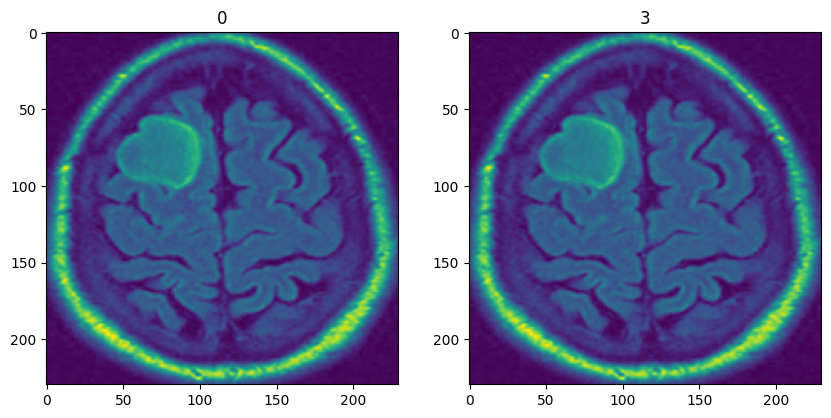

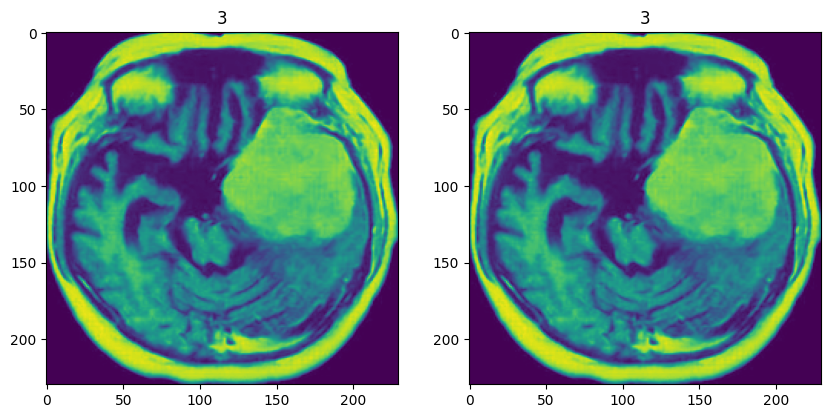

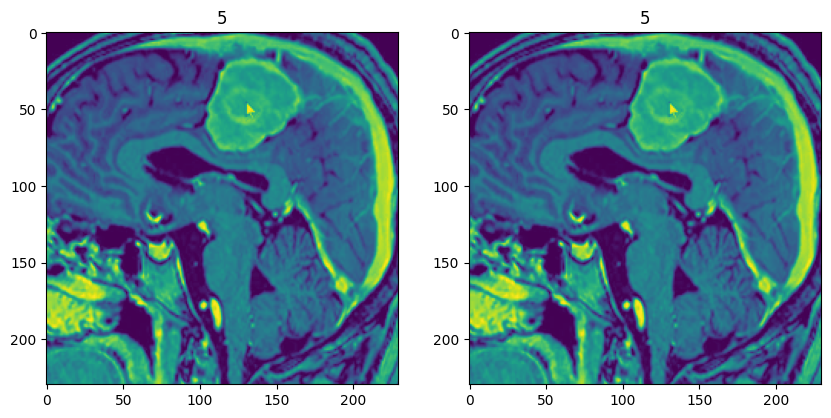

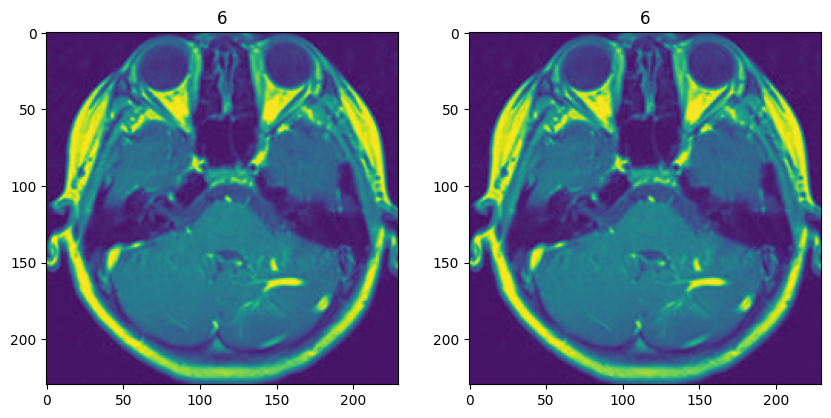

In [ ]:
for k in range(0, len(Xt), 100):
    fig = plt.figure(figsize=(10, 6))
    img1 = testing_data[k][0]
    fig.add_subplot(1, 2, 1)
    plt.title(f"{testing_data[k][1]}")
    plt.imshow(img1)
    img2 = Xt[k]
    fig.add_subplot(1, 2, 2)
    plt.title(f"{np.argmax(predictions[k])}")
    tumor_mask = (predictions[k] == np.argmax(predictions[k]))
    tumor_mask_uint8 = (tumor_mask * 255).astype(np.uint8)
    plt.imshow(img2)
    plt.show()

# Interface


## Janela Principal

In [ ]:
class MainWindow(QtWidgets.QMainWindow):

    def __init__(self, parent = None):
        QtWidgets.QMainWindow.__init__(self, parent)

        self.frame = QtWidgets.QFrame()

        self.vl = QtWidgets.QVBoxLayout()
        self.vtkWidget = QVTKRenderWindowInteractor(self.frame)
        self.vl.addWidget(self.vtkWidget)

        self.ren = vtk.vtkRenderer()
        self.vtkWidget.GetRenderWindow().AddRenderer(self.ren)
        self.iren = self.vtkWidget.GetRenderWindow().GetInteractor()

        # Create source
        source = vtk.vtkSphereSource()
        source.SetCenter(0, 0, 0)
        source.SetRadius(5.0)

        # Create a mapper
        mapper = vtk.vtkPolyDataMapper()
        mapper.SetInputConnection(source.GetOutputPort())

        # Create an actor
        actor = vtk.vtkActor()
        actor.SetMapper(mapper)

        self.ren.AddActor(actor)

        self.ren.ResetCamera()

        self.frame.setLayout(self.vl)
        self.setCentralWidget(self.frame)

        self.show()
        self.iren.Initialize()

In [ ]:
if __name__ == "__main__":

    app = QtWidgets.QApplication(sys.argv)

    window = MainWindow()

    sys.exit(app.exec_())